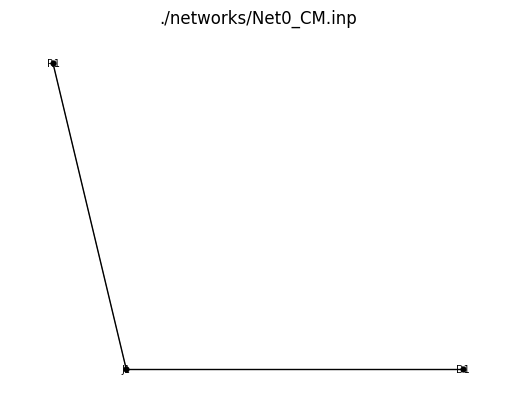

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [4]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

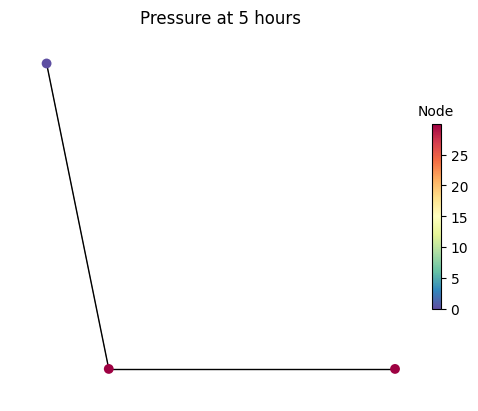

<Axes: title={'center': 'Pressure at 5 hours'}>

In [5]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [6]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)

In [7]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 7
step = (0.5/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+1.5, var_base_name="x")

nqbit = 7
step = (5/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+95.0, var_base_name="x")

In [8]:
from wntr_quantum.design.qubo_pipe_diam import QUBODesignPipeDiameter 
pipe_diameters = [250, 500, 1000]
designer = QUBODesignPipeDiameter(wn, flow_encoding, head_encoding, pipe_diameters, head_lower_bound=80)

In [9]:
designer.verify_encoding()

Head Encoding : 95.000000 => 100.000000 (res: 0.039370)
Flow Encoding : -2.000000 => -1.500000 | 1.500000 => 2.000000 (res: 0.003937)


In [10]:
designer.create_index_mapping()
designer.pipe_diameter_index_mapping['flow[P2]'][2]

11

In [11]:
(P0, P1,P2,P3,P4) = designer.initialize_matrices()

In [12]:
P1[:-1, 2:6] + P2.sum(1)[:-1, 2:6]

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  1., -1.]])

In [13]:
P2.shape

(5, 12, 12)

In [14]:
designer.matrices = designer.initialize_matrices()
designer.compute_classical_solution([1,0,0,1,0,0], convert_to_si=False)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([ 1.766,  1.766, 67.877, 37.329])

In [15]:
designer.enumerates_classical_solutions(convert_to_si=False)

price 	 diameters 	 variables
0.16907910944516957 [250. 250.] [ 1.766  1.766 67.877 37.329]
0.25361866416775436 [250. 500.] [ 1.766  1.766 67.877 67.118]
0.42269777361292393 [ 250. 1000.] [ 1.766  1.766 67.877 67.858]
0.25361866416775436 [500. 250.] [ 1.766  1.766 97.666 67.118]
0.33815821889033915 [500. 500.] [ 1.766  1.766 97.666 96.906]
0.5072373283355087 [ 500. 1000.] [ 1.766  1.766 97.666 97.647]
0.42269777361292393 [1000.  250.] [ 1.766  1.766 98.406 67.858]
0.5072373283355087 [1000.  500.] [ 1.766  1.766 98.406 97.647]
0.6763164377806783 [1000. 1000.] [ 1.766  1.766 98.406 98.387]


In [16]:
from dwave.samplers import SimulatedAnnealingSampler
options = {'sampler': SimulatedAnnealingSampler()}
status = designer.solve(strength=1E5, num_reads=100000, options=options)

/home/nico/miniconda3/envs/vitens_wntr_1/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:759: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


[1, 1, 1.748031496062992, 1.996062992125984, 98.2283464566929, 98.58267716535433]


In [17]:
designer.total_pice

0.6763164377806783

In [18]:
designer.optimal_diameters

array([1000., 1000.])

In [19]:
designer.bqm.num_variables

428